In [2]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import os
import pickle
import networkx as nx
import datetime
from tqdm import tqdm

c:\users\kasia\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
sns.set_style("whitegrid")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (6, 2.5)

pal = sns.color_palette("Set2", 8)

# Goverment in each period

In [8]:
df_gov = pd.read_csv('gov_coalisions.csv')

def string_to_list(s):
    return [el.strip() for el in s.split(",")]

df_gov['gov'] = df_gov['gov'].map(string_to_list)
df_gov.head()

,k,period,gov,opp,Unnamed: 4
0,3,1997_10,"[AWS, UW]","ROP, SLD, PSL",NaN
1,3,1997_11,"[AWS, UW]",NaN,NaN
2,3,1997_12,"[AWS, UW]",NaN,NaN
3,3,1998_01,"[AWS, UW]",NaN,NaN
4,3,1998_02,"[AWS, UW]",NaN,NaN


# Functions

In [9]:
def avg_network_distance(G, length_dict):
    G_nodes = list(G.nodes())
    dist = 0
    n = len(G_nodes)
    for i in range(n):
        for j in range(i+1, n):
            n_1 = G_nodes[i]
            n_2 = G_nodes[j]
            dist += length_dict[n_1][n_2]
    return dist / (n * (n-1))

In [10]:
def distance_between_2_groups(nodes_1, nodes_2, length_dict):
    dist = []
    for n1 in nodes_1:
        for n2 in nodes_2:
            dist.append(length_dict[n1][n2])
            
    return np.mean(dist), np.std(dist)

In [127]:
# def distance_between_2_groups(nodes_1, nodes_2, length_dict):
#     dist = 0
#     for n1 in nodes_1:
#         for n2 in nodes_2:
#             dist += length_dict[n1][n2]
            
#     return dist / (len(nodes_1) * len(nodes_2))

In [11]:
def nodes_per_party(G, unique_parties):
    node_per_party = [[] for i in range(len(unique_parties))]

    for node_id, node_party in dict(G.nodes(data='party')).items():
        for i in range(len(unique_parties)):
            if node_party == unique_parties[i]:
                node_per_party[i].append(node_id)
    return node_per_party

In [12]:
def nodes_per_coallition(unique_parties, gov, opp):
    gov_nodes = []
    opp_nodes = []

    for i in range(len(unique_parties)):
        party = unique_parties[i]
        if party in gov:
            gov_nodes += node_per_party[i]
        elif party in opp:
            opp_nodes += node_per_party[i]
    return gov_nodes, opp_nodes

# Monthly distances

In [13]:
df_dist_clubs = pd.DataFrame()
df_isolation_clubs = pd.DataFrame()
df_dist_gov_opp = pd.DataFrame()
df_global_avg_dist = pd.DataFrame()

for file_name in tqdm(os.listdir(f'graphs_backbone/monthly/')):
    f = file_name[2:-7]
    k = int(f[0:-8])
    period = f[-7:]
    
    G = pickle.load(open(f'graphs_backbone/monthly/{file_name}', 'rb'))
#     removing isolated nodes
#     G.remove_nodes_from(list(nx.isolates(G)))
    
    for n1, n2, e_weight in G.edges.data('weight'):
        G.edges[n1, n2]['distance'] = (2 * (1 - e_weight))**(1/2)

    length_dict = dict(nx.all_pairs_dijkstra_path_length(G, weight='distance'))
    unique_parties = list(set(dict(G.nodes(data='party')).values()))
    
    node_per_party = nodes_per_party(G, unique_parties)
    gov = list(df_gov[df_gov['period'] == period]['gov'])[0]
    opp = list(set(unique_parties).difference(set(gov)))
    gov_nodes, opp_nodes = nodes_per_coallition(unique_parties, gov, opp)
    
    # distance between all clubs
    for i in range(len(unique_parties)):
        p_1 = unique_parties[i]
        g_1 = node_per_party[i]
        for j in range(i+1, len(unique_parties)):
            p_2 = unique_parties[j]
            g_2 = node_per_party[j]
            dist, std = distance_between_2_groups(g_1, g_2, length_dict)

            df_dist = pd.DataFrame({'k': k,
                                    'period': period,
                                    'club1': [p_1, p_2],
                                    'club2': [p_2, p_1],
                                    'mean_dist': dist,
                                    'std': std
                                   })

            df_dist_clubs = pd.concat([df_dist_clubs, df_dist], ignore_index=True)
            
    # party isolation
    for i in range(len(unique_parties)):
        p_1 = unique_parties[i]
        g_1 = node_per_party[i]
        dist_isol = 0 
        dist_isol_std = 0
        g_2_total_size = 0
        for j in range(len(unique_parties)):
            if i != j:
                g_2 = node_per_party[j]
                g_2_total_size += len(g_2)
                dist, std = distance_between_2_groups(g_1, g_2, length_dict)
                dist_isol += len(g_2) * dist
                dist_isol_std += len(g_2) * std

        dist_isol = dist_isol / g_2_total_size
        dist_isol_std = dist_isol_std / g_2_total_size
        df_iso = pd.DataFrame({'k': [k],
                               'period': [period],
                               'club': [p_1],
                               'mean_isolation': [dist_isol],
                               'std_isolation': [dist_isol_std]
                              })

        df_isolation_clubs = pd.concat([df_isolation_clubs, df_iso], ignore_index=True)
        
    # gov vs opp
    dist_coal, std_coal = distance_between_2_groups(gov_nodes, opp_nodes, length_dict)

    df_dist_coal = pd.DataFrame({'k': k,
                                 'period': period,
                                 'gov': [gov],
                                 'opp': [opp],
                                 'mean_dist': dist_coal,
                                 'std': std_coal})

    df_dist_gov_opp = pd.concat([df_dist_gov_opp, df_dist_coal], ignore_index=True)
    
    # avg distance in G
    dist = avg_network_distance(G, length_dict)
    df_avg_dist = pd.DataFrame({'k': [k],
                                'period': [period],
                                'mean_dist': [dist]
                               })

    df_global_avg_dist = pd.concat([df_global_avg_dist, df_avg_dist], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████| 308/308 [2:28:52<00:00, 29.00s/it]


In [14]:
df_dist_clubs = df_dist_clubs.sort_values('period')
df_isolation_clubs = df_isolation_clubs.sort_values('period')
df_dist_gov_opp = df_dist_gov_opp.sort_values('period')
df_global_avg_dist = df_global_avg_dist.sort_values('period')

In [15]:
df_dist_clubs.to_csv('distances/df_dist_clubs.csv', index=False)
df_isolation_clubs.to_csv('distances/df_isolation_clubs.csv', index=False)
df_dist_gov_opp.to_csv('distances/df_dist_gov_opp.csv', index=False)
df_global_avg_dist.to_csv('distances/df_global_avg_dist.csv', index=False)

# Plots

In [4]:
df_dist_clubs = pd.read_csv('distances/df_dist_clubs.csv')
df_isolation_clubs = pd.read_csv('distances/df_isolation_clubs.csv')
df_dist_gov_opp = pd.read_csv('distances/df_dist_gov_opp.csv')
df_global_avg_dist = pd.read_csv('distances/df_global_avg_dist.csv')

In [5]:
df_dist_clubs['period'] = pd.to_datetime(df_dist_clubs['period'].str.replace('_', '-'), format='%Y-%m')
df_isolation_clubs['period'] = pd.to_datetime(df_isolation_clubs['period'].str.replace('_', '-'), format='%Y-%m')
df_dist_gov_opp['period'] = pd.to_datetime(df_dist_gov_opp['period'].str.replace('_', '-'), format='%Y-%m')
df_global_avg_dist['period'] = pd.to_datetime(df_global_avg_dist['period'].str.replace('_', '-'), format='%Y-%m')

In [6]:
df_dist_clubs['mean_dist'] = np.round(df_dist_clubs['mean_dist'], 4)
df_isolation_clubs['mean_isolation'] = np.round(df_isolation_clubs['mean_isolation'], 4)
df_dist_gov_opp['mean_dist'] = np.round(df_dist_gov_opp['mean_dist'], 4)
df_global_avg_dist['mean_dist'] = np.round(df_global_avg_dist['mean_dist'], 4)

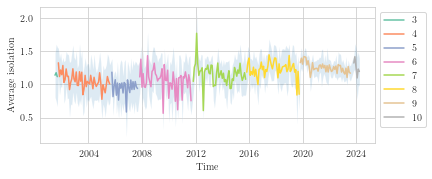

In [10]:
sns.lineplot(df_isolation_clubs[df_isolation_clubs['club'] == 'PiS'], x='period', y='mean_isolation', hue='k', palette=pal)
plt.xlabel('Time')
plt.ylabel('Average isolation')
plt.legend(bbox_to_anchor=(1, 1))
d = df_isolation_clubs[df_isolation_clubs['club'] == 'PiS']
plt.fill_between(d['period'], 
                 d['mean_isolation'] - d['std_isolation'],
                 d['mean_isolation'] + d['std_isolation'],
                 alpha=0.15)
plt.savefig('images/measures_in_time/mean_isolation_PiS.pdf', bbox_inches='tight')
plt.show()

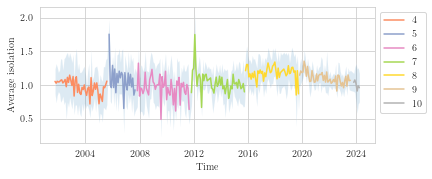

In [12]:
d = df_isolation_clubs[df_isolation_clubs['club'].isin(['PO', 'PO-KO', 'KO'])]

sns.lineplot(d, x='period', y='mean_isolation', hue='k', palette=pal[1:])
plt.xlabel('Time')
plt.ylabel('Average isolation')
plt.legend(bbox_to_anchor=(1, 1))
plt.fill_between(d['period'], 
                 d['mean_isolation'] - d['std_isolation'],
                 d['mean_isolation'] + d['std_isolation'],
                 alpha=0.15)
plt.savefig('images/measures_in_time/mean_isolation_PO.pdf', bbox_inches='tight')
plt.show()

In [17]:
# df_isolation_clubs['period'] = pd.to_datetime(df_isolation_clubs['period'].str.replace('_', '-'), format='%Y-%m')

begins = df_isolation_clubs.groupby('k')['period'].min().values
begins

array(['1997-10-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2007-11-01T00:00:00.000000000',
       '2011-11-01T00:00:00.000000000', '2015-11-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2023-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

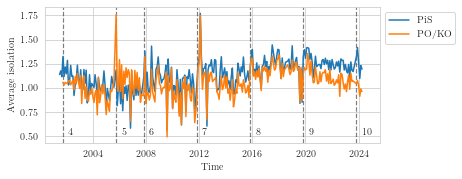

In [20]:
d_po = df_isolation_clubs[df_isolation_clubs['club'].isin(['PO', 'PO-KO', 'KO'])]
d_pis = df_isolation_clubs[df_isolation_clubs['club'] == 'PiS']

for i in range(len(begins)):
    plt.axvline(begins[i], 0, 1, alpha=0.5, c='black', ls='--', lw=1.2)
    plt.annotate(str(i+3), (begins[i]+np.timedelta64(150,'D'), 0.51))
    
sns.lineplot(d_pis, x='period', y='mean_isolation', label='PiS')
sns.lineplot(d_po, x='period', y='mean_isolation', label='PO/KO')

plt.xlabel('Time')
plt.ylabel('Average isolation')
plt.xlim(begins[1]-np.timedelta64(500,'D'), None)
plt.legend(bbox_to_anchor=(1, 1))
# plt.fill_between(d['period'], 
#                  d['mean_isolation'] - d['std_isolation'],
#                  d['mean_isolation'] + d['std_isolation'],
#                  alpha=0.15)
plt.savefig('images/measures_in_time/mean_isolation_PO_PiS.pdf', bbox_inches='tight')
plt.show()

In [ ]:
sns.lineplot(df_isolation_clubs[df_isolation_clubs['club'] == 'PiS'], x='period', y='mean_isolation', hue='k', palette=pal)
plt.xlabel('Time')
plt.ylabel('Average isolation')
plt.legend(bbox_to_anchor=(1, 1))
d = df_isolation_clubs[df_isolation_clubs['club'] == 'PiS']
plt.fill_between(d['period'], 
                 d['mean_isolation'] - d['std_isolation'],
                 d['mean_isolation'] + d['std_isolation'],
                 alpha=0.15)
plt.savefig('images/measures_in_time/mean_isolation_PiS.pdf', bbox_inches='tight')
plt.show()

In [54]:
df_isolation_clubs

,k,period,club,mean_isolation,std_isolation
0,3,1997-10-01,PSL,0.9993,0.192347
1,3,1997-10-01,ROP,1.2735,0.256827
2,3,1997-10-01,niez.,1.0879,0.277449
3,3,1997-10-01,AWS,1.1835,0.209065
4,3,1997-10-01,SLD,1.2742,0.202874
...,...,...,...,...,...
2700,10,2024-04-01,niez.,0.8483,0.395544
2701,10,2024-04-01,Polska2050-TD,0.7443,0.218090
2702,10,2024-04-01,Kukiz15,0.9871,0.217429
2703,10,2024-04-01,Lewica,0.7844,0.217327


In [22]:
df_dist_gov_opp['mean_dist'] = np.round(df_dist_gov_opp['mean_dist'], 2)
df_dist_gov_opp['period'] = pd.to_datetime(df_dist_gov_opp['period'].str.replace('_', '-'), format='%Y-%m')

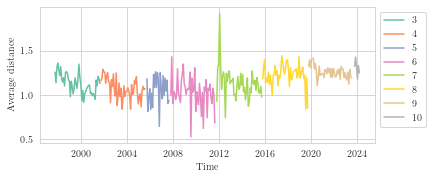

In [55]:
sns.lineplot(df_dist_gov_opp, x='period', y='mean_dist', hue='k', palette=pal)
plt.xlabel('Time')
plt.ylabel('Average distance')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('images/measures_in_time/avg_distance_gov_opp.pdf', bbox_inches='tight')
plt.show()

In [58]:
df_dist_gov_opp['std'].min()
df_dist_gov_opp['std'].max()

0.8485663345994675

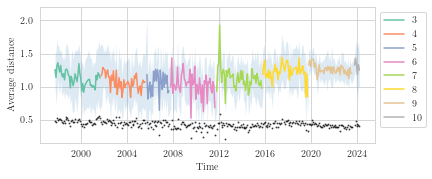

In [94]:
plt.fill_between(df_dist_gov_opp['period'], 
                 df_dist_gov_opp['mean_dist'] - df_dist_gov_opp['std'],
                 df_dist_gov_opp['mean_dist'] + df_dist_gov_opp['std'],
                 alpha=0.15)
sns.lineplot(df_dist_gov_opp, x='period', y='mean_dist', hue='k', palette=pal)
plt.scatter(df_global_avg_dist['period'], df_global_avg_dist['mean_dist'], color='black', alpha=0.6, s=1)
plt.ylim(0.15, 2.2)
plt.xlabel('Time')
plt.ylabel('Average distance')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('images/measures_in_time/avg_distance_gov_opp.pdf', bbox_inches='tight')
plt.show()

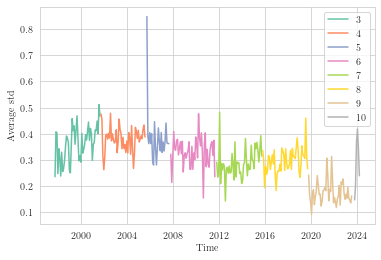

In [32]:
sns.lineplot(df_dist_gov_opp, x='period', y='std', hue='k', palette=pal)
plt.xlabel('Time')
plt.ylabel('Average std')
plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig('images/measures_in_time/avg_distance_gov_opp.pdf', bbox_inches='tight')
plt.show()

In [35]:
begins = df_dist_gov_opp.groupby('k')['period'].min().values
begins

array(['1997-10-01T00:00:00.000000000', '2001-10-01T00:00:00.000000000',
       '2005-10-01T00:00:00.000000000', '2007-11-01T00:00:00.000000000',
       '2011-11-01T00:00:00.000000000', '2015-11-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2023-11-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [33]:
df_dist_gov_opp

,k,period,gov,opp,mean_dist,std
6,3,1997-10-01,"[AWS, UW]","[PSL, ROP, niez., SLD]",1.26,0.235599
7,3,1997-11-01,"[AWS, UW]","[PSL, ROP, niez., SLD]",1.14,0.407275
8,3,1997-12-01,"[AWS, UW]","[PSL, ROP, niez., SLD]",1.32,0.403628
9,3,1998-01-01,"[AWS, UW]","[PSL, ROP, niez., SLD]",1.36,0.247309
10,3,1998-02-01,"[AWS, UW]","[PSL, ROP, niez., SLD]",1.28,0.342575
...,...,...,...,...,...,...
1,10,2023-12-01,"[KO, Lewica, Polska2050-TD, PSL-TD]","[Kukiz15, Konfederacja, PiS]",1.43,0.201203
2,10,2024-01-01,"[KO, Lewica, Polska2050-TD, PSL-TD]","[Kukiz15, Konfederacja, PiS]",1.33,0.368688
3,10,2024-02-01,"[KO, Lewica, Polska2050-TD, PSL-TD]","[Kukiz15, Konfederacja, PiS]",1.18,0.418413
4,10,2024-03-01,"[KO, Lewica, Polska2050-TD, PSL-TD]","[niez., Kukiz15, Konfederacja, PiS]",1.33,0.345675


<ipython-input-38-760336aedc98>:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(d_m, x='k', y='mean_dist', palette=pal)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


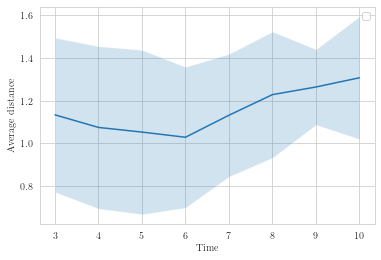

In [38]:
d_m = df_dist_gov_opp.groupby(['k'], as_index=False)['mean_dist'].mean()
d_std = df_dist_gov_opp.groupby(['k'], as_index=False)['std'].mean()

plt.fill_between(d_m['k'], 
                 d_m['mean_dist'] - d_std['std'],
                 d_m['mean_dist'] + d_std['std'],
                 alpha=0.2)
sns.lineplot(d_m, x='k', y='mean_dist', palette=pal)
plt.xlabel('Term')
plt.ylabel('Average distance')
# plt.legend(bbox_to_anchor=(1, 1))
# plt.savefig('images/measures_in_time/avg_distance_gov_opp.pdf', bbox_inches='tight')
plt.show()

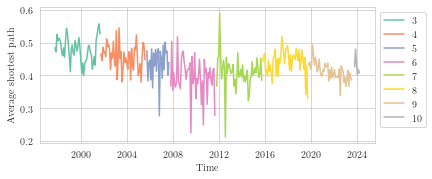

In [64]:
sns.lineplot(df_global_avg_dist, x='period', y='mean_dist', hue='k', palette=pal)
plt.xlabel('Time')
plt.ylabel('Average shortest path')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('images/measures_in_time/global_avg_dist.pdf', bbox_inches='tight')
plt.show()

In [14]:
sns.set_style("whitegrid")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams["figure.figsize"] = (8,3)

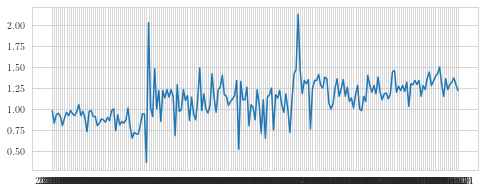

In [15]:
d = df_dist_clubs[(df_dist_clubs['club1'] == 'PO') & (df_dist_clubs['club2'] == 'PiS')]
plt.plot(d['period'], np.round(d['mean_dist'], 2))

Error in callback <function _draw_all_if_interactive at 0x0000020C3E6668B0> (for post_execute):


KeyboardInterrupt: 

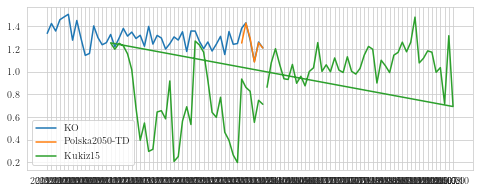

In [141]:
d = df_dist_clubs[(df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'] == 'KO')]
plt.plot(d['period'], d['mean_dist'], label='KO')

d = df_dist_clubs[(df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'] == 'Polska2050-TD')]
plt.plot(d['period'], d['mean_dist'], label='Polska2050-TD')

d = df_dist_clubs[(df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'] == 'Kukiz15')]
plt.plot(d['period'], d['mean_dist'], label='Kukiz15')
plt.legend()

In [130]:
df_dist_clubs[df_dist_clubs['period'] == '2016-02-01']['club1'].unique()

array(['PO', 'Kukiz15', 'niez.', 'N', 'PiS', 'PSL'], dtype=object)

In [138]:
df_dist_clubs[df_dist_clubs['k'] == 8]['club1'].unique()

array(['PiS', 'N', 'niez.', 'Kukiz15', 'PSL', 'PO', 'WiS', 'ED', 'UED',
       'Republikanie', 'PSL-UED', 'L-S', 'TERAZ!', 'W-S', 'PO-KO',
       'Konfederacja', 'PSL-KP', 'UPR', 'PP'], dtype=object)

In [140]:
d

,k,period,club1,club2,mean_dist,std
19218,9,2019-11-01,PiS,Konfederacja,2.1583,0.037963
19248,9,2019-12-01,PiS,Konfederacja,1.3477,0.048909
19277,9,2020-01-01,PiS,Konfederacja,1.2327,0.117428
19308,9,2020-02-01,PiS,Konfederacja,1.2367,0.091531
19329,9,2020-03-01,PiS,Konfederacja,1.3553,0.115642
19367,9,2020-04-01,PiS,Konfederacja,1.2813,0.025265
19399,9,2020-05-01,PiS,Konfederacja,1.2328,0.047499
19420,9,2020-06-01,PiS,Konfederacja,1.2563,0.029182
19458,9,2020-07-01,PiS,Konfederacja,1.1750,0.084504
19488,9,2020-08-01,PiS,Konfederacja,1.2092,0.240830


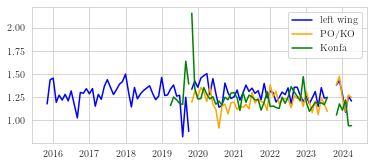

In [141]:
# d = df_dist_clubs[(df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'].isin(['PO', 'PO-KO', 'KO']))]
# plt.plot(d['period'], d['mean_dist'], label='PO/KO')

# d = df_dist_clubs[(df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'] == 'Konfederacja')]
# plt.plot(d['period'], d['mean_dist'], label='Konfederacja')

for k in [8, 9, 10]:
    d = df_dist_clubs[(df_dist_clubs['k'] == k) & (df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'].isin(['PO', 'PO-KO', 'KO']))]
    plt.plot(d['period'], d['mean_dist'], color='blue')
    
    d = df_dist_clubs[(df_dist_clubs['k'] == k) & (df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'].isin(['SLD', 'Lewica']))]
    plt.plot(d['period'], d['mean_dist'], color='orange')
    
    d = df_dist_clubs[(df_dist_clubs['k'] == k) & (df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'].isin(['Konfederacja']))]
    plt.plot(d['period'], d['mean_dist'], color='green')
    

plt.legend(['left wing', 'PO/KO', 'Konfa'])

In [102]:
from datetime import timedelta

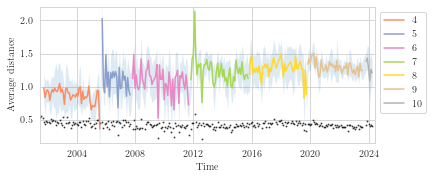

In [111]:
d = df_dist_clubs[(df_dist_clubs['club1'] == 'PiS') & (df_dist_clubs['club2'].isin(['PO', 'PO-KO', 'KO']))]

plt.fill_between(d['period'], 
                 d['mean_dist'] - d['std'],
                 d['mean_dist'] + d['std'],
                 alpha=0.15)
sns.lineplot(d, x='period', y='mean_dist', hue='k', palette=pal[1:])
plt.scatter(df_global_avg_dist['period'], df_global_avg_dist['mean_dist'], color='black', alpha=0.6, s=1)
plt.ylim(0.15, 2.2)
plt.xlim(d['period'].min()-timedelta(days=100), d['period'].max()+timedelta(days=60))
plt.xlabel('Time')
plt.ylabel('Average distance')
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('images/measures_in_time/avg_distance_PO_PIS.pdf', bbox_inches='tight')
plt.show()


In [105]:
d['period'].min()-timedelta(days=15)

Timestamp('2001-09-16 00:00:00')